In [2]:
from PIL import Image

from keras.layers import Input, Dense, Layer
from keras.models import Model
from keras.constraints import Constraint
from keras.regularizers import Regularizer

from keras import backend as K
from keras import regularizers

import tensorflow as tf
from tensorflow import keras

import numpy as np
import os

import matplotlib.pyplot as plt
from matplotlib.cm import *
from matplotlib.pyplot import imshow

import sklearn as sk
from sklearn import feature_extraction
import networkx as nx

print(keras.__version__)

Using TensorFlow backend.


2.2.4-tf


# Read the raster

In [3]:
#ROOT_DIR = "/home/charles/Projects/Water/"
ROOT_DIR = "/home/dhw3172/projects/water"

In [4]:
city="Mtl"
strNeigh="Poin_Sain_Vill"


In [5]:
rastPath=os.path.join(ROOT_DIR,"Data","GeoData","Raster", "DEM",f"{city}{strNeigh}Elev.tif")
rast = Image.open(rastPath)

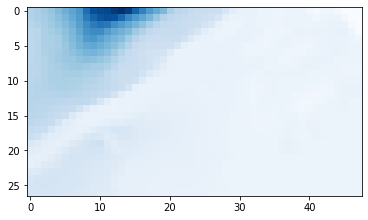

In [6]:
rast.show()
imshow(np.asarray(rast), get_cmap("Blues"))

In [7]:
numPixels=np.prod(rast.size)
print(numPixels)
rast.size

1296


(48, 27)

# Transform to numpy array

In [8]:
arr=np.array(rast) 
rastSizeTransposed=arr.shape
rastSizeTransposed

(27, 48)

In [9]:
arr

array([[66.99 , 71.01 , 75.84 , ...,  7.32 ,  7.   ,  7.   ],
       [65.75 , 69.49 , 73.46 , ..., 11.57 ,  7.05 ,  7.   ],
       [62.42 , 66.77 , 71.72 , ..., 19.39 , 11.35 ,  7.   ],
       ...,
       [36.17 , 38.62 , 39.5  , ..., 17.   , 17.   , 17.   ],
       [38.85 , 40.   , 39.9  , ..., 17.   , 17.   , 17.   ],
       [38.575, 39.075, 39.   , ..., 17.   , 17.   , 17.   ]],
      dtype=float32)

In [10]:
tens=arr[np.newaxis, ...]
tens.shape

(1, 27, 48)

# Try to convert the image to a graph (useful for fused lasso for adjacent pixels)

In [11]:
adjMat=sk.feature_extraction.image.img_to_graph(rast)

In [12]:
graph=nx.from_scipy_sparse_matrix(adjMat)

In [13]:
[(u,dat) for u,dat in graph.nodes(data=True) if u<=2]

[(0, {}), (1, {}), (2, {})]

In [14]:
[(u,v,dat) for u,v,dat in graph.edges(data=True) if u<=2]

[(0, 1, {'weight': 4.0200043}),
 (0, 48, {'weight': 1.2399979}),
 (0, 0, {'weight': 66.99}),
 (1, 2, {'weight': 4.829994}),
 (1, 49, {'weight': 1.5200043}),
 (1, 1, {'weight': 71.01}),
 (2, 3, {'weight': 6.7700043}),
 (2, 50, {'weight': 2.3799973}),
 (2, 2, {'weight': 75.84})]

In [15]:
#Get the incidence matrix
#Orientation yields +1 and -1 => perfect for fused lasso implemetnation
incMatrix=nx.incidence_matrix(graph, oriented=True).transpose()

In [16]:
incMatrix[1,].todense()

matrix([[-1.,  0.,  0., ...,  0.,  0.,  0.]])

In [17]:
incMatrix.todense()[1:]

matrix([[-1.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0., -1.,  1., ...,  0.,  0.,  0.],
        ...,
        [ 0.,  0.,  0., ...,  0., -1.,  1.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.]])

In [18]:
print( incMatrix.shape, type(incMatrix) )

(3813, 1296) <class 'scipy.sparse.csr.csr_matrix'>


In [17]:
assert(numPixels == len(graph.nodes()) )
dotProdResults=np.dot(incMatrix.todense(), np.random.randint(1,10,size=numPixels))
dotProdResults

matrix([[-2., -8.,  0., ..., -5.,  0.,  0.]])

In [18]:
dotProdResults.shape

(1, 3813)

In [19]:
nx, ny=rastSizeTransposed
arrFlatt=arr.reshape((nx,ny)).reshape(nx*ny)
print(arrFlatt.shape)
diffPixel=np.dot(incMatrix.todense(), arrFlatt)

(1296,)


In [20]:
print( np.min(dotProdResults), np.min( abs(dotProdResults) ) )

-8.0 0.0


# Fit the autoencoder

min_\hat{f} ||x-\hat{f}(x) ||
 

## Start with a single layer
\hat{f}(x) = sigma(a'x + b)

In [22]:
# Define a custom layer => one parameter per pixel (and not pixel X pixel parameters)

class ElementWiseMult(tf.keras.layers.Layer):

    def __init__(self,  kernel_regularizer=None, **kwargs):
        self.kernel_regularizer = regularizers.get(kernel_regularizer)
        
        print(self.kernel_regularizer)
        super(ElementWiseMult, self).__init__(**kwargs)
        

    def build(self, input_shape):

        print(f'Here is the dim{input_shape}')
        
        # Create a trainable weight variable for this layer.
        self.kernel = self.add_weight(name='kernel', 
                                      shape=(int(input_shape[-2]),int(input_shape[-1])),
                                      initializer='uniform',
                                      trainable=True,
                                      regularizer=self.kernel_regularizer)
        self.output_dim= input_shape[1]
        
        
        super(ElementWiseMult, self).build(input_shape)  # Be sure to call this at the end

    def call(self, x):
        return tf.multiply(x,      self.kernel )
    
    def compute_output_shape(self, input_shape):
        return (input_shape[-1], self.output_dim)


In [27]:
#Build the model
model = tf.keras.Sequential([
    ElementWiseMult(input_shape=rastSizeTransposed)
])

W0923 14:33:14.209734 139876125144896 deprecation.py:506] From /home/dhw3172/anaconda3/envs/pyAudio37/lib/python3.7/site-packages/tensorflow/python/keras/initializers.py:119: calling RandomUniform.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


None
Here is the dim(?, 27, 48)


In [41]:
'''
for reference 

tf.keras.Sequential([
    tf.keras.layers.Dense(32,input_shape=rast.size)
]).summary()
''' 

'\nfor reference \n\ntf.keras.Sequential([\n    tf.keras.layers.Dense(32,input_shape=rast.size)\n]).summary()\n'

In [42]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
element_wise_mult (ElementWi (None, 27, 48)            1296      
Total params: 1,296
Trainable params: 1,296
Non-trainable params: 0
_________________________________________________________________


In [48]:
#Compile and fit the model
model.compile(optimizer='adam',
             loss='mean_squared_error')

In [49]:
modelFit=model.fit(x=tens, y=tens, epochs=200, verbose=0)
print("Finished calibrating model")

Finished calibrating model


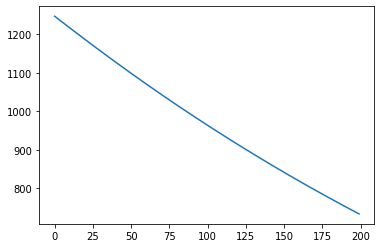

In [50]:
plt.plot(modelFit.epoch, modelFit.history['loss']) 

In [44]:
predImg=model.predict(tens)
predImg

array([[[-0.5828563 , -0.11851152, -0.34839016, ...,  0.25933933,
          0.29940847, -0.20536344],
        [-0.30316252,  0.49488723,  0.5819138 , ...,  0.16883981,
          0.17228505, -0.07855327],
        [ 2.3952675 , -1.0740107 , -1.1621416 , ..., -0.11550153,
          0.30418113,  0.01916717],
        ...,
        [-0.15853329, -0.06108952, -0.47942355, ...,  0.277029  ,
         -0.02360066, -0.40421098],
        [ 0.91682726, -0.45606807,  1.1407886 , ..., -0.54212046,
         -0.10660283,  0.5344349 ],
        [-1.1832038 ,  1.3305433 , -0.61433375, ..., -0.54281896,
         -0.6101341 , -0.2787638 ]]], dtype=float32)

In [45]:
np.min( abs(model.predict(tens) ) )

0.004604678

In [46]:
def normalize(x):
    mn=np.min(x)
    mx=np.max(x)
    
    xNorm=1-((mx-x)/(mx-mn))
    
    return(xNorm)

normMat=normalize(predImg[0,:,:])
print(normMat.shape)
normMat

(27, 48)


array([[0.4623409 , 0.48916954, 0.47588772, ..., 0.5110007 , 0.5133158 ,
        0.48415142],
       [0.47850084, 0.52461004, 0.5296382 , ..., 0.5057719 , 0.50597095,
        0.4914782 ],
       [0.63440883, 0.43396336, 0.4288714 , ..., 0.4893434 , 0.5135915 ,
        0.4971242 ],
       ...,
       [0.48685718, 0.4924872 , 0.46831697, ..., 0.51202273, 0.49465317,
        0.47266257],
       [0.5489886 , 0.46966642, 0.56192845, ..., 0.46469456, 0.48985755,
        0.526895  ],
       [0.42765445, 0.57289195, 0.46052223, ..., 0.46465415, 0.46076488,
        0.47991055]], dtype=float32)

In [47]:
def normalizePlotImg(img, fact=1):
    
    if(len(img.shape)>3 | len(img.shape)<2):
        raise("Fatal error, must input a tensor or dimension 2 or 3")
    
    if(len(img.shape)==3):
        normMat=normalize(img[0,:,:])
    else:
        normMat=normalize(img )
    
    #Normalize the matrix
    cmHot=get_cmap('Blues')
    
    #Get the color with the Blues color map
    predImgCM=cmHot(normMat)
    
    predImgCM=np.uint8(predImgCM*255)
    i=Image.fromarray(predImgCM)
    
    #Resize
    nx, ny= predImgCM.shape[0:2] #this is a width X heigh X rgba matrix
    if(int(np.ceil(ny*fact))<=0 | int(np.ceil(nx*fact))<=0):
        raise("Fatal error, cannot choose such a small factor for image resizing, must have at least 1 pixel!")
    i=i.resize( (int(np.ceil(ny*fact)), int(np.ceil(nx*fact) ) ) ) #transpose to go from raster/pixel grid to array
    
    i.show()
    
    return(i)

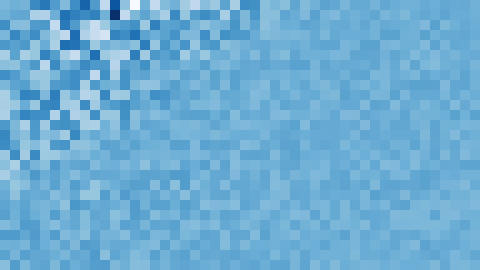

In [48]:
origImg= normalizePlotImg(predImg,fact=10)
origImg
#nx, ny= predImg.shape[1:] 
#fact=10
#origImg.resize( (ny*fact, nx*fact ) ) #transpose to go from raster/pixel grid to array

# With regular lasso

In [49]:
#Build the model
model = tf.keras.Sequential([
    ElementWiseMult(input_shape=rastSizeTransposed, 
                    kernel_regularizer=keras.regularizers.l1(l=1000),
                   )
])

Here is the dim(?, 27, 48)


In [50]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
element_wise_mult_1 (Element (None, 27, 48)            1296      
Total params: 1,296
Trainable params: 1,296
Non-trainable params: 0
_________________________________________________________________


In [152]:
model.compile(optimizer='adam',
             loss='mean_squared_error')
modelFit=model.fit(tens,tens,epochs=10000,verbose=0)

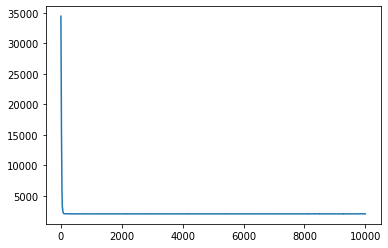

In [153]:
plt.plot(modelFit.epoch, modelFit.history['loss']) 

In [154]:
np.min( abs(model.predict(tens) ) )

3.3116883e-06

In [155]:
predImg=model.predict(tens)

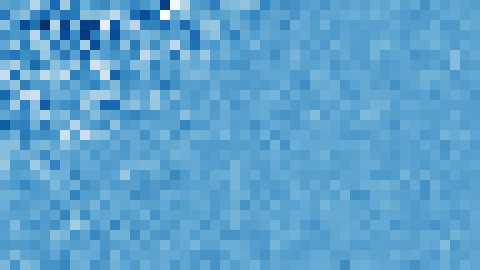

In [157]:
normalizePlotImg(predImg,fact=10)

# With custom fused lasso

In [51]:
"""
def fused_l1_reg(weightMat, penWeight = 1000):
    
    nx, ny=weightMat.shape
    arrFlatt=tf.reshape(weightMat, [-1]) nx*ny
    
    diffPixel= abs( np.dot(incMatrix.todense(), arrFlatt) )
    
    return penWeight * diffPixel
"""

In [ ]:
def fused_l1_with_reg_lasso(weightMat, penWeightLassoFused= 1000, penWeightLassoStd = 1000 ):
    
    if( np.min(penWeightLassoFused,penWeightLassoStd ) < 0):
        raise("Fatal error, use non-negative penalty weights!")
    
    nx, ny=weightMat.shape
    arrFlatt=tf.reshape(weightMat, [-1] ) #nx*ny - flatten the matrix - ie transform mat for col vector
    
    regularization = 0.
    
    #Fused lasso component
    if(penWeightLassoFused > 0)
    regularization +=  penWeightLassoFused * abs( np.dot(incMatrix.todense(), arrFlatt) )
    
    #Std lasso component
    regularization += penWeightLassoStd * abs( arrFlatt )
 
    return regularization

## Simple wrappers

In [93]:
 

def get_fused_l1_with_reg_lasso_zeroFusedLasso(penWeightLassoStd=1000 ):
    def fused_l1_with_reg_lasso_zeroFusedLasso(weightMat, penWeightLassoFused=0, penWeightLassoStd=penWeightLassoStd):
        fused_l1_with_reg_lasso(weightMat, penWeightLassoFused=penWeightLassoFused, penWeightLassoStd=penWeightLassoStd)
    return(fused_l1_with_reg_lasso_zeroFusedLasso)

def get_fused_l1_with_reg_lasso_zeroLasso(penWeightLassoFused=1000 ):
    def fused_l1_with_reg_lasso_zeroLasso(weightMat, penWeightLassoFused=penWeightLassoFused, penWeightLassoStd=0):
        fused_l1_with_reg_lasso(weightMat, penWeightLassoFused=penWeightLassoFused, penWeightLassoStd=penWeightLassoStd)
    return(fused_l1_with_reg_lasso_zeroLasso)


 
manRegOnlyFused=get_fused_l1_with_reg_lasso_zeroLasso(penWeightLassoFused = 1000)
manRegOnlyStd=get_fused_l1_with_reg_lasso_zeroFusedLasso(penWeightLassoStd = 1000)

In [82]:
rastSizeTransposed
incMatrix.todense().shape

(3813, 1296)

## Replicate the std lasso results - ie 0 fused lasso penalty

In [94]:
#Build the model 
model = tf.keras.Sequential([
    ElementWiseMult(input_shape=rastSizeTransposed, 
                    kernel_regularizer=manRegOnlyStd,
                   )
])

<function get_fused_l1_with_reg_lasso_zeroFusedLasso.<locals>.fused_l1_with_reg_lasso_zeroFusedLasso at 0x7fd7907881e0>
Here is the dim(?, 27, 48)


In [95]:
model.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
element_wise_mult_6 (Element (None, 27, 48)            1296      
Total params: 1,296
Trainable params: 1,296
Non-trainable params: 0
_________________________________________________________________


In [ ]:
model.compile(optimizer='adam',
             loss='mean_squared_error')
modelFit=model.fit(tens,tens,epochs=100)

In [ ]:
predImg=model.predict(tens)
normalizePlotImg(predImg,fact=10)

## Only fused lasso - no variable selection - ie 0 std lasso penalty

In [ ]:
model = tf.keras.Sequential([
    ElementWiseMult(input_shape=rastSizeTransposed, 
                    kernel_regularizer=manRegOnlyFused,
                   )
])

In [ ]:
model.compile(optimizer='adam',
             loss='mean_squared_error')
modelFit=model.fit(tens,tens,epochs=100,verbose=1)

In [ ]:
predImg=model.predict(tens)
normalizePlotImg(predImg,fact=10)

## With custom fused lasso + variable selection

In [ ]:
#Build the model
model = tf.keras.Sequential([
    ElementWiseMult(input_shape=rastSizeTransposed, 
                    kernel_regularizer=fused_l1_with_reg_lasso 
                   )
])

In [ ]:
model.summary()

In [ ]:
model.compile(optimizer='adam',
             loss='mean_squared_error')
modelFit=model.fit(tens,tens,epochs=10000,verbose=0)

In [45]:



''' 

#Custom regularizer classes


class fused_l1(Regularizer):
    """Regularizer for fused lasso - no regular var selection
    """

    def __init__(self, penWeight):
        self.lasso1 = K.cast_to_floatx(penWeight)
 

    def __call__(self, x):
        
        nx, ny=x.shape
        arrFlatt=x.reshape(nx*ny)

        diffPixel= abs( np.dot(incMatrix.todense(), arrFlatt) )
    
        return penWeight * diffPixel
        
 
'''

'''

class fused_l1_with_reg_lasso(Regularizer):
    """Regularizer for fused lasso - no regular var selection
    """

    def __init__(self, penWeightLassoFused, penWeightLassoStd ):
        self.penWeightLassoFused = K.cast_to_floatx(penWeightLassoFused)
        self.penWeightLassoStd = K.cast_to_floatx(penWeightLassoStd)

    def __call__(self, x):
        regularization = 0.
        regularization += self.fusedPenWeight * K.sum(K.abs(x))

        return regularization
        
'''




"""
cmHot=get_cmap('Blues')
predImgHot=cmHot(normMat)
predImgHot=np.uint8(predImgHot*255)
i=Image.fromarray(predImgHot)
i.show()

img=Image.fromarray(np.array(predImg[0,:,:]))
#img.save('my.png')
img.show()
"""



'''
Tests with tf eval and tf.multiply

x=tf.constant(5.0, shape=[5, 6])
y=tf.constant([i for i in range(6)],dtype='float32')
v=tf.constant(np.ones(shape=(5,6))*9,dtype='float32')

mat=tf.multiply(x, y)
mat2=tf.multiply(x,v)

with tf.Session():
    m=mat.eval()
    m2=mat2.eval()
    xe=x.eval()
    ye=y.eval()
    print(m2)
    print(m)
    print(xe)
    print(ye)
    print(v.eval())
'''




"""

#Define a diag matrix

arr=np.array((1,100,999,2)).reshape(2,2)
print(arr)
d=np.diag(arr,)

x=np.ones(2)
print( np.dot(x,arr) )
print( np.dot(x,d) )
"""




"""
Possible to use    tf.keras.layers.Dense(kernel_constraint = DiagonalWeight ) to impose using only the diagonal elements.
but this still requires creating a npixels X npixels matrix, which is too large


class DiagonalWeight(Constraint):
    #Constrains the weights to be diagonal.
    def __call__(self, w):
        N = K.int_shape(w)[-1]
        m = K.eye(N)
        w *= m
        return w
        
"""



"""
# Define a custom layer => one parameter per pixel (and not pixel X pixel parameters)

class DiagMapping(tf.keras.layers.Layer):

    def __init__(self, **kwargs):
        super(DiagMapping, self).__init__(**kwargs)
        

    def build(self, input_shape):

        # Create a trainable weight variable for this layer.
        self.kernel = self.add_weight(name='kernel', 
                                      shape=(int(input_shape[-1]),1),
                                      initializer='uniform',
                                      trainable=True)
        self.output_dim= input_shape[-1]
        print(f'Here is the dim{input_shape}')
        
        super(DiagMapping, self).build(input_shape)  # Be sure to call this at the end

    def call(self, x):
        return tf.multiply(x,      self.kernel )
    
    def compute_output_shape(self, input_shape):
        return (self.output_dim, self.output_dim)


"""



"""
def fused_l1_reg(weightMat, penWeight):
    
    nx, ny=weightMat.shape
    arrFlatt=weightMat.reshape(nx*ny)
    
    print(arrFlatt.shape)
    
    diffPixel= abs( np.dot(incMatrix.todense(), arrFlatt) )
    
    return penWeight * diffPixel

 
fused_l1_reg( np.arange(nx * ny ).reshape((nx, ny)) , penWeight=10)

fused_l1_reg( np.arange(nx * ny ).reshape((nx, ny)), penWeight=1 )
"""

'\ndef fused_l1_reg(weightMat, penWeight):\n    \n    nx, ny=weightMat.shape\n    arrFlatt=weightMat.reshape(nx*ny)\n    \n    print(arrFlatt.shape)\n    \n    diffPixel= abs( np.dot(incMatrix.todense(), arrFlatt) )\n    \n    return penWeight * diffPixel\n\n \nfused_l1_reg( np.arange(nx * ny ).reshape((nx, ny)) , penWeight=10)\n\nfused_l1_reg( np.arange(nx * ny ).reshape((nx, ny)), penWeight=1 )\n'